# 中心性を使った感染症の制御のシミュレーションをPythonで再現してみた
> 参考文献：小蔵正輝, 中心性を使った感染症の制御, 経済セミナー, no. 717, pp. 42-46, 2020.

## 必要なモジュールのインポート

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import time

## 空手ネットワークの可視化

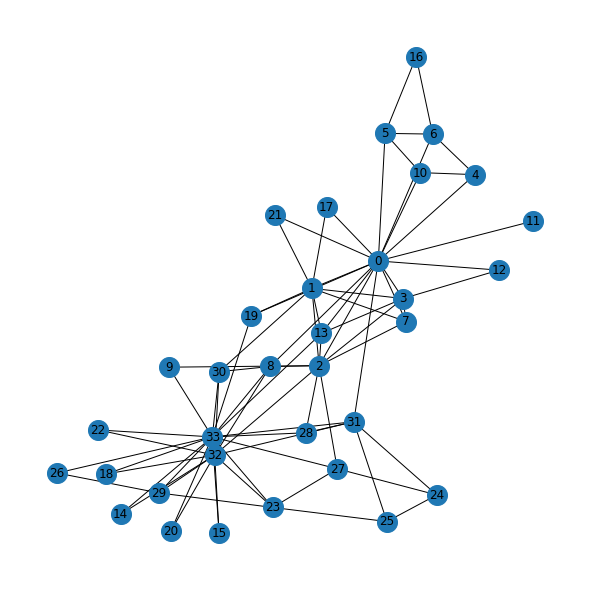

In [3]:
np.random.seed(20)
G = nx.karate_club_graph()
plt.figure(figsize=(8,8))
nx.draw_spring(G, node_size=400,with_labels=True)

plt.savefig('karate_network.png')
plt.show()

## 最初の感染者をランダムに選択し，2つ先の隣接ノードまで感染するモデル

## ワクチンなしの感染症シミュレーション

In [5]:
T = 100 # 反復回数

I_num_list = [] # 感染者数のリスト
for _ in range(T):
    node = random.randint(0,nx.number_of_nodes(G)-1) # 最初の感染者をランダムに選択
    I_list = [node] # 感染者リストの生成
    I_list.extend(list(G.adj[node])) # 最初の感染者の隣接ノード(1次感染者)を感染者リストに格納
    I_list = list(set(I_list)) # 重複している感染者ノードを1つにまとめる
    search_list = I_list[:] # 2次感染者を探すためのリストを現在の感染者リストからコピー
    search_list.remove(node) # 2次感染者を調べるノードから最初の感染者を除く
    for v in search_list: # 2次感染者を調べていく
        I_list.extend(list(G.adj[v])) # 2次感染者を感染者リストに格納
        I_list = list(set(I_list)) # 重複している感染者ノードを1つにまとめる
        I_num_list.append(len(I_list)) # あとで感染者数平均を求めるために感染者数をリストに追加する
I_ave = np.average(I_num_list) # 感染者数平均を求める
print("感染者数平均：" + str(I_ave))

感染者数平均：21.066666666666666


## ワクチンを1人だけ打つシミュレーション

In [9]:
N = 1
T = 100
I_min = 100000 # 感染者数平均の最小値を格納するため，初期値は無限大にしておく

t1 = time.time()
I_ave_list = []
for i in range(nx.number_of_nodes(G)): # ワクチン接種者を全ノードで試す
    vaccinated = i
    I_num_list = []
    for _ in range(T):
        node = random.randint(0,nx.number_of_nodes(G)-1)
        if node == vaccinated: # 最初の感染者がワクチン接種者の場合
            I_num_list.append(0) # この場合の感染者数は0
        else:
            I_list = [node]
            I_list.extend(list(G.adj[node]))
            I_list = list(set(I_list))
            if vaccinated in list(G.adj[node]): # 最初の感染者の隣接ノードにワクチン接種者がいる場合
                I_list.remove(vaccinated) # ワクチン接種者を感染者リストから除く
            search_list = I_list[:]
            search_list.remove(node)
            for v in search_list:
                I_list.extend(list(G.adj[v]))
                I_list = list(set(I_list))
                if vaccinated in I_list: # 2次感染者にワクチン接種者がいる場合
                    I_list.remove(vaccinated) # ワクチン接種者を感染者リストから除く
            I_num_list.append(len(I_list))
    I_ave = np.average(I_num_list)
    I_ave_list.append(I_ave)
    if I_min > I_ave:
        I_min = I_ave
        vac_min = vaccinated
t2 = time.time()
print(f"計算時間：{t2-t1}")
print(f"最小値のノード：{vac_min}  感染者数平均の最小値：{I_min}")

data = []
data.append([N,vac_min,I_min,t2-t1])

計算時間：0.05884218215942383
最小値のノード：0  感染者数平均の最小値：14.79


## 図2　ワクチンを与えるノードと感染者数平均Iの値の関係

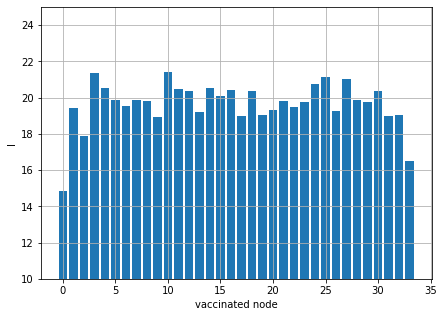

In [13]:
num_list = []
for i in range(nx.number_of_nodes(G)):
    num_list.append(i)
    
plt.figure(figsize=(7,5))
plt.bar(num_list,I_ave_list)
plt.xlabel("vaccinated node")
plt.ylabel("I")
plt.ylim(10,25)
plt.grid(True)

plt.savefig('vaccinated_node.png')

## ワクチンを2人だけ打つシミュレーション

In [10]:
N = 2 # ワクチンの本数
T = 100
I_min = 100000

t1 = time.time() # タイマー開始
for j in range(nx.number_of_nodes(G)):
    for i in range(nx.number_of_nodes(G)):
        if i == j or i > j: # 同じ組み合わせを省略
            continue
        else:
            vaccine_list = [i,j] # i番のノードとj番のノードがワクチン接種者
        I_num_list = [] 
        for _ in range(T):
            node = random.randint(0,nx.number_of_nodes(G)-1)
            if node in vaccine_list:
                I_num_list.append(0)
            else:
                I_list = [node]
                I_list.extend(list(G.adj[node]))
                I_list = list(set(I_list))
                for v in range(len(vaccine_list)): # ここをvaccine_listに変更，リスト内の要素すべてを調べる
                    if vaccine_list[v] in list(G.adj[node]): # ワクチン接種者が初期感染者の隣接ノードである場合
                        I_list.remove(vaccine_list[v])
                search_list = I_list[:]
                search_list.remove(node)
                for v in search_list:
                    I_list.extend(list(G.adj[v]))
                    I_list = list(set(I_list))
                    for v in range(len(vaccine_list)): # ここもvaccine_list
                        if vaccine_list[v] in I_list: # 感染者リストにワクチン接種者がいる場合
                            I_list.remove(vaccine_list[v]) # ワクチン接種者を感染者リストから除く
                I_num_list.append(len(I_list))
        I_ave = np.average(I_num_list)
        if I_min > I_ave:
            I_min = I_ave
            vac_min = vaccine_list
t2 = time.time() # タイマー終了
print(f"計算時間：{t2-t1}")
print("最小値の組：" + str(vac_min) + " 感染者数平均の最小値I：" + str(I_min))
data.append([N,vac_min,I_min,t2-t1])

計算時間：1.0598745346069336
最小値の組：[0, 33] 感染者数平均の最小値I：10.93


In [11]:
# ワクチン3本
N = 3
T = 100
I_min = 100000

t1 = time.time()
for k in range(nx.number_of_nodes(G)):
    for j in range(nx.number_of_nodes(G)):
        for i in range(nx.number_of_nodes(G)):
            if i == j or j == k or k == i or i > j or j > k:
                continue
            else:
                vaccine_list = [i,j,k]
            I_num_list = []
            for _ in range(T):
                node = random.randint(0,nx.number_of_nodes(G)-1)
                if node in vaccine_list:
                    I_list = []
                    I_num_list.append(len(I_list))
                else:
                    I_list = [node]
                    I_list.extend(list(G.adj[node]))
                    I_list = list(set(I_list))
                    for v in range(len(vaccine_list)):
                        if vaccine_list[v] in list(G.adj[node]):
                            I_list.remove(vaccine_list[v])
                    search_list = I_list[:]
                    search_list.remove(node)
                    for v in search_list:
                        I_list.extend(list(G.adj[v]))
                        I_list = list(set(I_list))
                        for v in range(len(vaccine_list)):
                            if vaccine_list[v] in I_list:
                                I_list.remove(vaccine_list[v])
                    I_num_list.append(len(I_list))
            I_ave = np.average(I_num_list)
            #print(str(vaccine_list) + "：" + str(I_ave))
            if I_min > I_ave:
                I_min = I_ave
                vac_min = vaccine_list
t2 = time.time()
print(f"計算時間：{t2-t1}")
print("最小の組：" + str(vac_min) + " 感染者数平均の最小値I：" + str(I_min))
data.append([N,vac_min,I_min,t2-t1])

計算時間：12.300414562225342
最小の組：[0, 32, 33] 感染者数平均の最小値I：6.96


In [12]:
# ワクチン4本
N = 4
T = 100
I_min = 100000

t1 = time.time()
for l in range(nx.number_of_nodes(G)):
    for k in range(nx.number_of_nodes(G)):
        for j in range(nx.number_of_nodes(G)):
            for i in range(nx.number_of_nodes(G)):
                if i == j or i == k or i == l or j == k or j == l or k == l or i > j or j > k or k > l:
                    continue
                else:
                    vaccine_list = [i,j,k,l]
                I_num_list = []
                for _ in range(T):
                    node = random.randint(0,nx.number_of_nodes(G)-1)
                    if node in vaccine_list:
                        I_list = []
                        I_num_list.append(len(I_list))
                    else:
                        I_list = [node]
                        I_list.extend(list(G.adj[node]))
                        I_list = list(set(I_list))
                        for v in range(len(vaccine_list)):
                            if vaccine_list[v] in list(G.adj[node]):
                                I_list.remove(vaccine_list[v])
                        search_list = I_list[:]
                        search_list.remove(node)
                        for v in search_list:
                            I_list.extend(list(G.adj[v]))
                            I_list = list(set(I_list))
                            for v in range(len(vaccine_list)):
                                if vaccine_list[v] in I_list:
                                    I_list.remove(vaccine_list[v])
                        I_num_list.append(len(I_list))
                I_ave = np.average(I_num_list)
                #print(str(vaccine_list) + "：" + str(I_ave))
                if I_min > I_ave:
                    I_min = I_ave
                    vac_min = vaccine_list
t2 = time.time()
print(f"計算時間：{t2-t1}")
print("最小の組：" + str(vac_min) + " 感染者数平均：" + str(I_min))
data.append([N,vac_min,I_min,t2-t1])

計算時間：100.57757019996643
最小の組：[0, 2, 32, 33] 感染者数平均：4.43


## 表１空手ネットワークにおける最適なワクチン配置

In [13]:
col = ['本数','頂点の組','感染者数平均','計算時間（秒）']
df = pd.DataFrame(data, columns = col)
print(df)

   本数            頂点の組  感染者数平均     計算時間（秒）
0   1               0   14.79    0.058842
1   2         [0, 33]   10.93    1.059875
2   3     [0, 32, 33]    6.96   12.300415
3   4  [0, 2, 32, 33]    4.43  100.577570


## 次数中心性

In [14]:
# 次数中心性
N = 5
T = 100
t1 = time.time()

data2 = []
vaccine_list = []
v_tuple = list(sorted(nx.degree_centrality(G).items(),key=lambda x: x[1],reverse=True)[:N]) # ここで中心性の上位5つを求める
for v in list(v_tuple):
    vaccine_list.append(v[0]) # 5つのノードのワクチン接種者リスト
print(f"ノードの組 {vaccine_list}")

I_num_list = []
for _ in range(T):
    node = random.randint(0,nx.number_of_nodes(G)-1)
    if node in vaccine_list:
        I_list = []
        I_num_list.append(len(I_list))
    else:
        I_list = [node]
        I_list.extend(list(G.adj[node]))
        I_list = list(set(I_list))
        for v in range(len(vaccine_list)):
            if vaccine_list[v] in list(G.adj[node]):
                I_list.remove(vaccine_list[v])
        search_list = I_list[:]
        search_list.remove(node)
        for s in search_list:
            I_list.extend(list(G.adj[s]))
            I_list = list(set(I_list))
            for v in range(len(vaccine_list)):
                if vaccine_list[v] in I_list:
                    I_list.remove(vaccine_list[v])
        I_num_list.append(len(I_list))
I_ave = np.average(I_num_list)
t2 = time.time()
print(f"感染者数平均：{I_ave}")
print(f"計算時間：{t2-t1}")

data2.append([vaccine_list,I_ave,t2-t1])

ノードの組 [33, 0, 32, 2, 1]
感染者数平均：3.34
計算時間：0.0019941329956054688


## 媒介中心性

In [15]:
# 媒介中心性
N = 5
T = 100
t1 = time.time()
between_centers = nx.betweenness_centrality(G)
print(sorted(between_centers.items(),key=lambda x: x[1],reverse=True)[:N])

vaccine_list = []
v_tuple = list(sorted(nx.betweenness_centrality(G).items(),key=lambda x: x[1],reverse=True)[:N])
for v in list(v_tuple):
    vaccine_list.append(v[0])
print(f"頂点の組 {vaccine_list}")
 
I_num_list = []
for _ in range(T):
    node = random.randint(0,nx.number_of_nodes(G)-1)
    if node in vaccine_list:
        I_list = []
        I_num_list.append(len(I_list))
    else:
        I_list = [node]
        I_list.extend(list(G.adj[node]))
        I_list = list(set(I_list))
        for v in range(len(vaccine_list)):
            if vaccine_list[v] in list(G.adj[node]):
                I_list.remove(vaccine_list[v])
        search_list = I_list[:]
        search_list.remove(node)
        for s in search_list:
            I_list.extend(list(G.adj[s]))
            I_list = list(set(I_list))
            for v in range(len(vaccine_list)):
                if vaccine_list[v] in I_list:
                    I_list.remove(vaccine_list[v])
        I_num_list.append(len(I_list))
I_ave = np.average(I_num_list)
t2 = time.time()
print(I_ave)
print(f"計算時間：{t2-t1}")

data2.append([vaccine_list,I_ave,t2-t1])

[(0, 0.43763528138528146), (33, 0.30407497594997596), (32, 0.145247113997114), (2, 0.14365680615680618), (31, 0.13827561327561325)]
頂点の組 [0, 33, 32, 2, 31]
4.33
計算時間：0.011941194534301758


## 近接中心性

In [16]:
# 近接中心性
N = 5
T = 100
t1 = time.time()
close_centers = nx.closeness_centrality(G)
print(sorted(nx.closeness_centrality(G).items(),key=lambda x: x[1],reverse=True)[:N])

vaccine_list = []
v_tuple = list(sorted(nx.closeness_centrality(G).items(),key=lambda x: x[1],reverse=True)[:N])
for v in list(v_tuple):
    vaccine_list.append(v[0])
print(f"頂点の組 {vaccine_list}")

I_num_list = []
for _ in range(T):
    node = random.randint(0,nx.number_of_nodes(G)-1)
    if node in vaccine_list: 
        I_list = [] 
        I_num_list.append(len(I_list))
    else:
        I_list = [node]
        I_list.extend(list(G.adj[node]))
        I_list = list(set(I_list))
        for v in range(len(vaccine_list)):
            if vaccine_list[v] in list(G.adj[node]): 
                I_list.remove(vaccine_list[v])
        search_list = I_list[:]
        search_list.remove(node)
        for s in search_list:
            I_list.extend(list(G.adj[s]))
            I_list = list(set(I_list))
            for v in range(len(vaccine_list)):
                if vaccine_list[v] in I_list:
                    I_list.remove(vaccine_list[v])
        I_num_list.append(len(I_list))
I_ave = np.average(I_num_list)
t2 = time.time()
print(I_ave)
print(f"計算時間：{t2-t1}")

data2.append([vaccine_list,I_ave,t2-t1])

[(0, 0.5689655172413793), (2, 0.559322033898305), (33, 0.55), (31, 0.5409836065573771), (8, 0.515625)]
頂点の組 [0, 2, 33, 31, 8]
6.48
計算時間：0.005984783172607422


## 固有ベクトル中心性

In [17]:
# 固有ベクトル中心性
N = 5
T = 100
t1 = time.time()
eigen_centers = nx.eigenvector_centrality(G)
print(sorted(eigen_centers.items(),key=lambda x: x[1],reverse=True)[:N])

vaccine_list = []
v_tuple = list(sorted(nx.eigenvector_centrality(G).items(),key=lambda x: x[1],reverse=True)[:N])
for v in list(v_tuple):
    vaccine_list.append(v[0])
print(f"頂点の組 {vaccine_list}")

I_num_list = [] 
for _ in range(T):
    node = random.randint(0,nx.number_of_nodes(G)-1)
    if node in vaccine_list:
        I_list = [] 
        I_num_list.append(len(I_list))
    else:
        I_list = [node]
        I_list.extend(list(G.adj[node]))
        I_list = list(set(I_list))
        for v in range(len(vaccine_list)):
            if vaccine_list[v] in list(G.adj[node]):
                I_list.remove(vaccine_list[v])
        search_list = I_list[:]
        search_list.remove(node)
        for s in search_list:
            I_list.extend(list(G.adj[s]))
            I_list = list(set(I_list))
            for v in range(len(vaccine_list)):
                if vaccine_list[v] in I_list:
                    I_list.remove(vaccine_list[v])
        I_num_list.append(len(I_list))
I_ave = np.average(I_num_list)
t2 = time.time()
print(I_ave)
print(f"計算時間：{t2-t1}")

data2.append([vaccine_list,I_ave,t2-t1])

[(33, 0.373371213013235), (0, 0.3554834941851943), (2, 0.31718938996844476), (32, 0.3086510477336959), (1, 0.2659538704545025)]
頂点の組 [33, 0, 2, 32, 1]
2.99
計算時間：0.005983591079711914


In [18]:
from tqdm import tqdm

# ワクチン5本
N = 5
T = 100
I_min = 100000

t1 = time.time()
for m in range(nx.number_of_nodes(G)):
    for l in range(nx.number_of_nodes(G)):
        for k in range(nx.number_of_nodes(G)):
            for j in range(nx.number_of_nodes(G)):
                for i in range(nx.number_of_nodes(G)):
                    if i == j or i == k or i == l or i == m or j == k or j == l or j == m or\
                        k == l or k == m or l == m or i > j or j > k or k > l or l > m:
                        continue
                    else:
                        vaccine_list = [i,j,k,l,m]
                    I_num_list = []
                    for _ in range(T):
                        node = random.randint(0,nx.number_of_nodes(G)-1)
                        if node in vaccine_list: 
                            I_list = [] 
                            I_num_list.append(len(I_list))
                        else:
                            I_list = [node]
                            I_list.extend(list(G.adj[node]))
                            I_list = list(set(I_list))
                            for v in range(len(vaccine_list)):
                                if vaccine_list[v] in list(G.adj[node]):
                                    I_list.remove(vaccine_list[v])
                            search_list = I_list[:]
                            search_list.remove(node)
                            for s in search_list:
                                I_list.extend(list(G.adj[s]))
                                I_list = list(set(I_list))
                                for v in range(len(vaccine_list)):
                                    if vaccine_list[v] in I_list:
                                        I_list.remove(vaccine_list[v])
                            I_num_list.append(len(I_list))
                    I_ave = np.average(I_num_list)
                    if I_min > I_ave:
                        I_min = I_ave
                        vac_min = vaccine_list
t2 = time.time()
print(f"計算時間：{t2-t1}")
print("最小の組：" + str(vac_min) + " 感染者数平均：" + str(I_min))

data2.append([vac_min,I_min,t2-t1])

計算時間：639.6198782920837
最小の組：[0, 1, 2, 32, 33] 感染者数平均：2.75


## 表2 ワクチン配置法の比較(k = 5の場合)

In [19]:
ind2 = ['次数中心性','媒介中心性','近接中心性','固有ベクトル中心性','全列挙']
col2 = ['頂点の組','感染者数平均','計算時間']
df2 = pd.DataFrame(data2, index = ind2, columns = col2)
print(df2)

                         頂点の組  感染者数平均        計算時間
次数中心性       [33, 0, 32, 2, 1]    3.34    0.001994
媒介中心性      [0, 33, 32, 2, 31]    4.33    0.011941
近接中心性       [0, 2, 33, 31, 8]    6.48    0.005985
固有ベクトル中心性   [33, 0, 2, 32, 1]    2.99    0.005984
全列挙         [0, 1, 2, 32, 33]    2.75  639.619878
